#### Build an LSTM-based next-word prediction model using a public dataset.
- Text preprocessing, tokenization, LSTM architecture, model training, prediction
- Sherlock Holmes Stories (public domain)

In [1]:
import torch
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import random
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import kagglehub
import os

In [2]:
# Download NLTK data
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
# !pip install kagglehub

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Uncomment the following line to download the dataset
# Download latest version
# path = kagglehub.dataset_download("idevji1/sherlock-holmes-stories")

# print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sherlock-holmes-stories


###### PATH=`C:\Users\DELL\.cache\kagglehub\datasets\idevji1\sherlock-holmes-stories\versions\1`

In [6]:
# Uncomment the following line to set dataset path
# path='/kaggle/input/sherlock-holmes-stories/sherlock'

In [5]:
# comment following line if you have already downloaded the dataset because it will overwrite the above "path"
path='/kaggle/input/sherlock-holmes-stories/sherlock'

In [6]:
# extracting all text files from the dataset path and combine into a single string
all_text = ""
for fname in os.listdir(path):
    if fname.endswith('.txt'):
        with open(os.path.join(path, fname), encoding='utf-8') as f:
            all_text += f.read() + "\n"

print(all_text[:1000])  # Print the first 1000 characters as a sample





                       THE ADVENTURE OF THE BLUE CARBUNCLE

                               Arthur Conan Doyle



     I had called upon my friend Sherlock Holmes upon the second morning
     after Christmas, with the intention of wishing him the compliments of
     the season. He was lounging upon the sofa in a purple dressing-gown,
     a pipe-rack within his reach upon the right, and a pile of crumpled
     morning papers, evidently newly studied, near at hand. Beside the
     couch was a wooden chair, and on the angle of the back hung a very
     seedy and disreputable hard-felt hat, much the worse for wear, and
     cracked in several places. A lens and a forceps lying upon the seat
     of the chair suggested that the hat had been suspended in this manner
     for the purpose of examination.

     "You are engaged," said I; "perhaps I interrupt you."

     "Not at all. I am glad to have a friend with whom I can discuss my
     results. The matter is a perfectly trivial one"--h

In [7]:
from nltk.corpus import stopwords
import re
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Sample text
# samall_text = """
# Mr. Sherlock Holmes, who was usually very late in the mornings, save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.
# I stood upon the hearth-rug and picked up the stick which our visitor had left behind him the night before.
# """


# text preprocessing and tokenization

# Remove extra spaces and tokenize
filtered_text = re.sub(r'\s+', ' ', all_text)
tokens = [w for w in word_tokenize(filtered_text.lower()) if w.isalpha() and w not in stop_words]
tokens = word_tokenize(all_text.lower())
vocab = sorted(set(tokens))
wordtoidx = {w: i for i, w in enumerate(vocab)}
idxtoword = {i: w for w, i in wordtoidx.items()}

In [9]:
# preparing sequences for training (sequence length = 5)
seq_length = 5
sequences = []
for i in range(len(tokens) - seq_length):
    seq = tokens[i:i+seq_length]
    target = tokens[i+seq_length]
    sequences.append((seq, target))

In [10]:
# convert word to indices
def sequenceToTensor(seq):
    return torch.tensor([wordtoidx[w] for w in seq], dtype=torch.long)

X = torch.stack([sequenceToTensor(seq) for seq, _ in sequences])
y = torch.tensor([wordtoidx[target] for _, target in sequences], dtype=torch.long)
batch_size = 256
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


##### LSTM Model

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=3):
        super(LSTMModel, self).__init__()
        # vocab_size: number of unique words in the vocabulary
        # embed_size: size of the word embedding vectors
        # hidden_size: number of features in the hidden state of each LSTM layer
        # num_layers: number of stacked LSTM layers

        self.embedding=nn.Embedding(vocab_size, embed_size)
        self.hidden_size=hidden_size
        self.num_layers=num_layers

        # LSTM gate weights and biases for each layer
        # W_ii: input-to-input gate weights
        # W_hi: hidden-to-input gate weights
        # b_i: input gate biases
        self.W_ii=nn.ParameterList([nn.Parameter(torch.Tensor(embed_size if i == 0 else hidden_size, hidden_size)) for i in range(num_layers)])
        self.W_hi=nn.ParameterList([nn.Parameter(torch.Tensor(hidden_size, hidden_size)) for _ in range(num_layers)])
        self.b_i=nn.ParameterList([nn.Parameter(torch.zeros(hidden_size)) for _ in range(num_layers)])

        # W_if: input-to-forget gate weights
        # W_hf: hidden-to-forget gate weights
        # b_f: forget gate biases
        self.W_if=nn.ParameterList([nn.Parameter(torch.Tensor(embed_size if i == 0 else hidden_size, hidden_size)) for i in range(num_layers)])
        self.W_hf=nn.ParameterList([nn.Parameter(torch.Tensor(hidden_size, hidden_size)) for _ in range(num_layers)])
        self.b_f=nn.ParameterList([nn.Parameter(torch.zeros(hidden_size)) for _ in range(num_layers)])

        # W_io: input-to-output gate weights
        # W_ho: hidden-to-output gate weights
        # b_o: output gate biases
        self.W_io=nn.ParameterList([nn.Parameter(torch.Tensor(embed_size if i == 0 else hidden_size, hidden_size)) for i in range(num_layers)])
        self.W_ho=nn.ParameterList([nn.Parameter(torch.Tensor(hidden_size, hidden_size)) for _ in range(num_layers)])
        self.b_o=nn.ParameterList([nn.Parameter(torch.zeros(hidden_size)) for _ in range(num_layers)])

        # W_ig: input-to-cell gate weights (candidate cell state)
        # W_hg: hidden-to-cell gate weights
        # b_g: cell gate biases
        self.W_ig=nn.ParameterList([nn.Parameter(torch.Tensor(embed_size if i == 0 else hidden_size, hidden_size)) for i in range(num_layers)])
        self.W_hg=nn.ParameterList([nn.Parameter(torch.Tensor(hidden_size, hidden_size)) for _ in range(num_layers)])
        self.b_g=nn.ParameterList([nn.Parameter(torch.zeros(hidden_size)) for _ in range(num_layers)])

        # Fully connected layer to map hidden state to vocabulary size (output logits)
        self.fc=nn.Linear(hidden_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        # Initialize weights using Xavier uniform initialization
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x, hidden=None):
        batch_size, seq_len = x.size()
        x = self.embedding(x)

        if hidden is None:
            # Initialize hidden and cell states to zeros
            h_t = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
            c_t = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        else:
            h_t, c_t = hidden

        for t in range(seq_len):
            x_t = x[:, t, :]
            for layer in range(self.num_layers):
                input_t = x_t if layer == 0 else h_t[layer - 1]
                # LSTM gate calculations
                i_t = torch.sigmoid(input_t @ self.W_ii[layer] + h_t[layer] @ self.W_hi[layer] + self.b_i[layer])  # input gate
                f_t = torch.sigmoid(input_t @ self.W_if[layer] + h_t[layer] @ self.W_hf[layer] + self.b_f[layer])  # forget gate
                o_t = torch.sigmoid(input_t @ self.W_io[layer] + h_t[layer] @ self.W_ho[layer] + self.b_o[layer])  # output gate
                g_t = torch.tanh(input_t @ self.W_ig[layer] + h_t[layer] @ self.W_hg[layer] + self.b_g[layer])     # cell candidate
                c_t[layer] = f_t * c_t[layer] + i_t * g_t  # update cell state
                h_t[layer] = o_t * torch.tanh(c_t[layer])   # update hidden state

        out = self.fc(h_t[-1])  # Output logits for the last hidden state
        return out, (h_t, c_t)

##### Hyperparameters

In [12]:
vocab_size = len(vocab)
embed_size = 32
hidden_size = 64
num_epochs = 50
lr = 0.001

model = LSTMModel(vocab_size, embed_size, hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

##### Training

In [13]:
losses = []
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for X_train, y_train in dataloader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        output, _ = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

Epoch 1/50, Loss: 5.2895
Epoch 2/50, Loss: 4.4749
Epoch 3/50, Loss: 4.1968
Epoch 4/50, Loss: 4.0109
Epoch 5/50, Loss: 3.8679
Epoch 6/50, Loss: 3.7524
Epoch 7/50, Loss: 3.6580
Epoch 9/50, Loss: 3.5137
Epoch 10/50, Loss: 3.4574
Epoch 12/50, Loss: 3.3683
Epoch 13/50, Loss: 3.3314
Epoch 14/50, Loss: 3.2993
Epoch 15/50, Loss: 3.2710
Epoch 16/50, Loss: 3.2454
Epoch 17/50, Loss: 3.2223
Epoch 18/50, Loss: 3.2019
Epoch 19/50, Loss: 3.1831
Epoch 20/50, Loss: 3.1656
Epoch 21/50, Loss: 3.1495
Epoch 22/50, Loss: 3.1360
Epoch 23/50, Loss: 3.1225
Epoch 24/50, Loss: 3.1099
Epoch 25/50, Loss: 3.0989
Epoch 26/50, Loss: 3.0879
Epoch 27/50, Loss: 3.0776
Epoch 28/50, Loss: 3.0683
Epoch 29/50, Loss: 3.0597
Epoch 30/50, Loss: 3.0515
Epoch 31/50, Loss: 3.0433
Epoch 32/50, Loss: 3.0355
Epoch 33/50, Loss: 3.0288
Epoch 34/50, Loss: 3.0221
Epoch 35/50, Loss: 3.0157
Epoch 36/50, Loss: 3.0101
Epoch 37/50, Loss: 3.0047
Epoch 38/50, Loss: 2.9991
Epoch 39/50, Loss: 2.9940
Epoch 41/50, Loss: 2.9845
Epoch 42/50, Loss: 2

##### Plotting loss

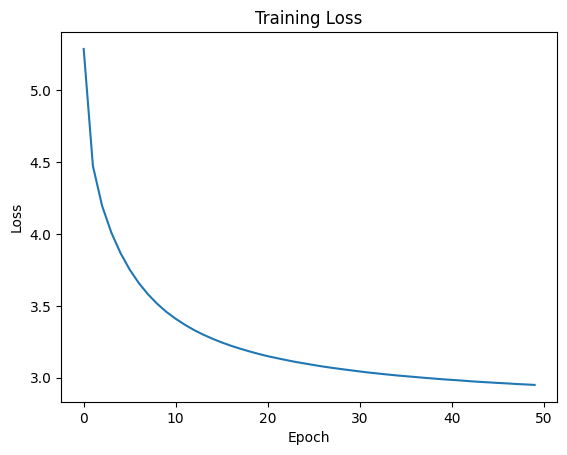

In [14]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

##### Text generation

In [16]:
def generate_text(model, start_seq, length=10):
    model.eval()
    seq = start_seq.copy()
    generated = seq.copy()
    hidden = None
    for _ in range(length):
        x = sequenceToTensor(seq).unsqueeze(0).to(device)
        with torch.no_grad():
            out, hidden = model(x, hidden)
            pred_idx = out.argmax(dim=1).item()
        pred_word = idxtoword[pred_idx]
        generated.append(pred_word)
        seq = seq[1:] + [pred_word]
    return ' '.join(generated)

start_seq = tokens[:seq_length]
print("Generated text:")
print(generate_text(model, start_seq, length=30))

Generated text:
the adventure of the blue carbuncle which hung fiercely in in the dwindling , which grow through the stairs which he terrified us in a wooden foolscap curling thrust upon the railings and waistcoat the


In [17]:
torch.save(model.state_dict(), 'lstm_sherlock_model.pth')